In [16]:
import os

from river import datasets
from river import metrics
from river import tree
from river import ensemble
from river import evaluate
from river import compose
from river import naive_bayes
from river import anomaly
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from confluent_kafka import Producer,Consumer,TopicPartition
import certifi
import time
import json
import pandas
import sys

In [17]:
user= os.environ['KAFKA_USER_NAME']
password= os.environ['KAFKA_PASSWORD']
bsts= os.environ['KAFKA_BOOTSTRAP_SERVERS']

In [18]:

def consume_messages(group_id,model_artifact,max_messages,feature_topic,partitions):    
    features_consumer_conf = {'bootstrap.servers': bsts,
                          'sasl.username': user,
                          'sasl.password': password,
                          'sasl.mechanism': 'PLAIN',
                          'security.protocol': 'SASL_SSL',
                          'ssl.ca.location': certifi.where(),
                          'group.id': group_id,
                          'enable.auto.commit': True,
                          'auto.commit.interval.ms':1000,         
                          'auto.offset.reset': 'latest'}
    features_consumer = Consumer(features_consumer_conf)  
    
    print(f'\nNow subscribing to features topic:{feature_topic}')
        
    #features_consumer.subscribe([feature_topic])
    tps = []
    for p in range(partitions):
        tps.append(TopicPartition(feature_topic,p))
    
    features_consumer.assign(tps)
    
    cnt = 0
    ignored=0
    msg = None
    error_cnt = 0
    end_learn_ts = 0
    st_learn_ts = 0

    st_processing_time = 0
    
    learning_durations=[]
    prediction_durations=[]
    processing_durations = []
    score_and_truth = []
    mem_usage = []
    end_to_end_processing_durations = []
    messaging_latencies = []
    while(True):           
        if(cnt>0 and cnt%max_messages==0):
            break;
        messages = features_consumer.consume(num_messages=1000,timeout=0.1)    
        if len(messages)==0: continue
        
        for msg in messages:
            if msg is None: continue
            if msg.error():
                error_cnt = error_cnt + 1
                if msg.error().code() == KafkaError._PARTITION_EOF:                    
                        if(error_cnt%1000==0):
                            print('error')
                            print(msg)
                        sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                                 (msg.topic(), msg.partition(), msg.offset()))
            else:       
                try:         
                    msg_arrival_time = time.time()
                    message = json.loads(msg.value().decode("utf-8"))            
                    cnt = cnt + 1

                    f = message['f']
                    y = (message['y']=='true')              
                    msg_produce_ts = message['st']
                    messaging_latencies.append(msg_arrival_time-msg_produce_ts)
                    if(cnt==1):
                        st_processing_time = time.time()

                    st_learn_ts = time.time()
                    model_artifact = model_artifact.learn_one(f,y)      
                    end_learn_ts = time.time()
                    learning_durations.append(end_learn_ts-st_learn_ts)            
                        
                    st_prediction_time = time.time()            
                    score = model_artifact.predict_one(f)
                    score_and_truth.append({'y':y,'score':score})
                    end_prediction_time = time.time()  
                    prediction_durations.append(end_prediction_time-st_prediction_time)


                    msg_departure_time = time.time()
                    processing_durations.append(msg_departure_time-msg_arrival_time)
                    end_to_end_processing_durations.append(msg_departure_time-msg_produce_ts)
                    if(cnt%1000==0):
                        print(f'Processed {cnt}')
                        mem_usage.append(model_artifact._raw_memory_usage)
                    if(cnt%max_messages==0):
                        break;
                except Exception as  e:      
                    if(cnt%max_messages==0):
                        break;
                    #print(json.loads(msg.value().decode("utf-8")))
                    #print(e, file=sys.stdout)
                    ignored = ignored + 1
                    if(ignored%100==0):
                        print(e, file=sys.stdout)
                        print(f'ignored ={ignored} total = {cnt}')

    total_time = time.time() - st_processing_time
    features_consumer.commit()
    features_consumer.close() 
    
    print(f'Closing Consumer - Total time take in seconds {total_time}')
    return score_and_truth,messaging_latencies,processing_durations,end_to_end_processing_durations, prediction_durations, learning_durations,mem_usage,total_time

In [19]:
import statistics
from river import metrics

def get_record(type_of_duration,durations):
  
   return {'Type of durations' :type_of_duration,
        'MEAN':statistics.mean(durations)*1000,
        'MEDIAN':statistics.median(durations)*1000,
        'MAXIMUM':max(durations)*1000,
        'MINIMUM':min(durations)*1000
        }
    
def get_results(score_and_truth,messaging_latencies,processing_durations,end_to_end_processing_durations, prediction_durations, learning_durations,mem_usage,total_time):
    auc = metrics.ROCAUC()
    f1 = metrics.F1()
    recall = metrics.MicroRecall()
    for m in score_and_truth:
        y = m['y']
        score = m['score']
        auc = auc.update(y,score)
        f1 = f1.update(y, score)
        recall = recall.update(y, score)
    
  
    total_records = len(score_and_truth)
    
    avg_memory_usage = None
    if len(mem_usage)>0:     
        avg_memory_usage = statistics.mean(mem_usage)
    print(f'Messages consumed:{total_records},Total Cumulative Time (seconds): {total_time}')    
    print(f'{auc}')
    print(f'{f1}')
    print(f'{recall}')
    print(f'AVERAGE MEMORY USAGE {avg_memory_usage}')
    
    d=[]
 
   
    d.append(get_record('MESSAGING LATENCY(ms)',messaging_latencies))
    d.append(get_record('PROCESSING DURATIONS ON ARRIVAL(ms)',processing_durations))
    d.append(get_record('    PREDICTION DURATIONS ON ARRIVAL(ms)',prediction_durations))
    d.append(get_record('    LEARNING DURATIONS ON ARRIVAL(ms)',learning_durations))
    d.append(get_record('END TO END DURATIONS(ms)',end_to_end_processing_durations))
                          
    df = pandas.DataFrame(data=d)
    return df


In [20]:
model_artifact = ensemble.AdaptiveRandomForestClassifier(leaf_prediction="mc")
group_id = 'ADRF_1'
max_messages = 5000
feature_topic = 'features'
no_of_partitions=16

score_and_truth,messaging_latencies,processing_durations, end_to_end_processing_durations,prediction_durations, learning_durations,mem_usage,total_time = consume_messages(group_id,model_artifact,max_messages,feature_topic,no_of_partitions)



Now subscribing to features topic:features
Processed 1000
Processed 2000
Processed 3000
Processed 4000
Processed 5000
Closing Consumer - Total time take in seconds 16.660043954849243


In [22]:
df = get_results(score_and_truth,messaging_latencies,processing_durations, end_to_end_processing_durations,prediction_durations, learning_durations,mem_usage,total_time)
display(df)


Messages consumed:5000,Total Cumulative Time (seconds): 16.660043954849243
ROCAUC: 88.90%
F1: 87.81%
MicroRecall: 88.90%
AVERAGE MEMORY USAGE 6980849.4


,Type of durations,MEAN,MEDIAN,MAXIMUM,MINIMUM
0,MESSAGING LATENCY(ms),588.168214,568.474650,1570.853472,135.467291
1,PROCESSING DURATIONS ON ARRIVAL(ms),1.704940,1.635790,81.044436,0.465631
2,PREDICTION DURATIONS ON ARRIVAL(ms),0.225795,0.211716,0.965595,0.101805
3,LEARNING DURATIONS ON ARRIVAL(ms),1.423568,1.347542,80.717087,0.325680
4,END TO END DURATIONS(ms),589.873154,569.671512,1572.169542,137.967110


## Types of Durations

Note how the messaging latency accounts for most of the latency. A faster and more expensive cluster will improve throughput proportionately (We process 800 records per second for the model ensemble.AdaptiveRandomForestClassifier(leaf_prediction="mc")

|    | Type of durations                   |       MEAN |     MEDIAN |     MAXIMUM |     MINIMUM |
|---:|:------------------------------------|-----------:|-----------:|------------:|------------:|
|  0 | MESSAGING LATENCY(ms)               | 972.558    | 956.883    | 1663.33     | 390.412     |
|  1 | PROCESSING DURATIONS ON ARRIVAL(ms) |   1.34578  |   1.28746  |   42.8333   |   0.345469  |
|  2 | PREDICTION DURATIONS ON ARRIVAL(ms) |   0.175217 |   0.167131 |    0.539541 |   0.0786781 |
|  3 | LEARNING DURATIONS ON ARRIVAL(ms)   |   1.13075  |   1.07217  |   42.6424   |   0.233173  |
|  4 | END TO END DURATIONS(ms)            | 973.903    | 958.406    | 1665.24     | 391.795     |

<AxesSubplot: >

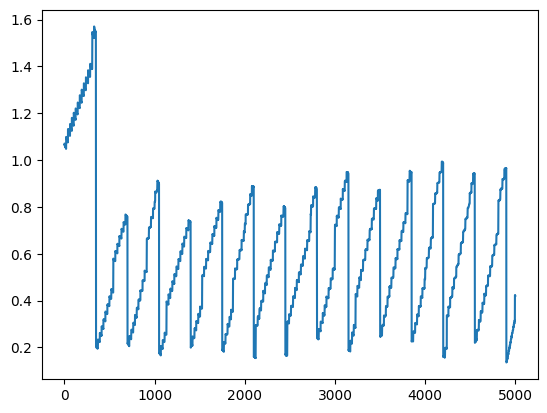

In [23]:
pandas.Series(messaging_latencies).plot()

<AxesSubplot: >

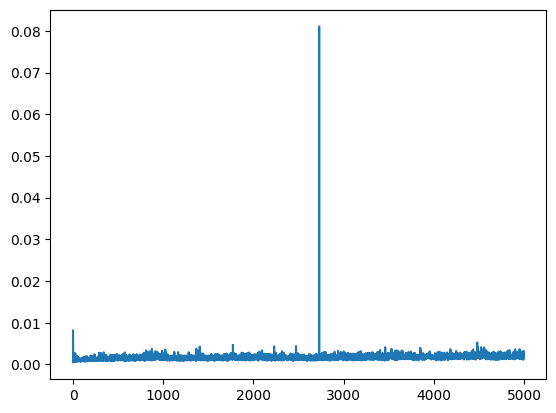

In [24]:
pandas.Series(processing_durations).plot()

<AxesSubplot: >

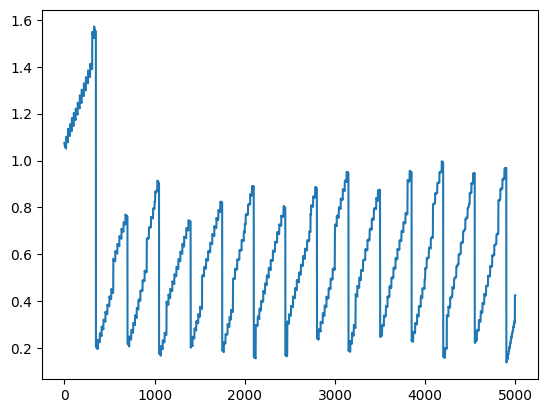

In [25]:
pandas.Series(end_to_end_processing_durations).plot()